In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pickle
import os
import base64
from os import listdir
import csv
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
file_path = '/content/drive/My Drive/Final Year 2024 PPS/Sanjeev_doc/post_dict.pickle'


with open(file_path, 'rb') as f:
    encoded_data = f.read()

# Decode the Base64-encoded data
decoded_bytes = base64.b64decode(encoded_data)

# Deserialize the object using pickle
img_dict = pickle.loads(decoded_bytes)
print(img_dict.keys())


dict_keys(['x', 'y'])


In [ ]:
import numpy as np
from scipy.ndimage import zoom

x_resized = []
y_resized = []

for i in img_dict['x']:
    resized_x = zoom(i, (224/i.shape[0], 224/i.shape[1], 1), order=1)
    x_resized.append(resized_x)

for i in img_dict['y']:

    y_resized.append(i)

# Convert lists to numpy arrays
x_resized = np.array(x_resized)
y_resized = np.array(y_resized)

print("Resized x shape:", x_resized.shape)
print("Resized y shape:", y_resized.shape)


Resized x shape: (1700, 224, 224, 3)
Resized y shape: (1700, 5)


In [ ]:
y_resized=y_resized.astype(float)
x_data=x_resized
y_data=y_resized

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dropout,MaxPooling2D,Dense,Input,Reshape, BatchNormalization,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
import math
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model without the fully connected layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable=False
vgg_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in vgg_base.layers:
  print(layer,"  ",layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7ed1fd124fa0>    False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1f01540d0>    False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1f0155db0>    False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ed1f0156020>    False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1f0156d40>    False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1f0157340>    False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ed1f0155a50>    False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1f01579a0>    False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1f0154f40>    False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1f006fbb0>    False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ed1dc598250>    False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1f006f550>    False
<keras.src.l

In [ ]:

# Add custom fully connected layers
x = Flatten()(vgg_base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
output = Dense(5)(x)

# Create the model
classifier = Model(inputs=vgg_base.input, outputs=output)

# Compile the model
loss = MeanSquaredError()
classifier.compile(optimizer=Adam(learning_rate=0.0001), loss=loss, metrics=[tf.keras.metrics.MeanSquaredError()])

# classifier.compile(optimizer='adam', loss=loss, metrics=[tf.keras.metrics.MeanSquaredError()])

classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=5, verbose=1)

# Train the model with the callback
history = classifier.fit(x_data, y_data, epochs=20, batch_size=64, callbacks=[reduce_lr], validation_split=0.2)


Epoch 1/20
22/22 [==============================] - 7s 309ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0728 - val_mean_squared_error: 0.0728 - lr: 1.0000e-04
Epoch 2/20
22/22 [==============================] - 7s 312ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0723 - val_mean_squared_error: 0.0723 - lr: 1.0000e-04
Epoch 3/20
22/22 [==============================] - 8s 373ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0717 - val_mean_squared_error: 0.0717 - lr: 1.0000e-04
Epoch 4/20
22/22 [==============================] - 8s 378ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0711 - val_mean_squared_error: 0.0711 - lr: 1.0000e-04
Epoch 5/20
22/22 [==============================] - 8s 386ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0706 - val_mean_squared_error: 0.0706 - lr: 1.0000e-04
Epoch 6/20
22/22 [==============================] - 7s 334ms/step - loss: 0.0137 - mean_squared_error: 0.

In [ ]:
# Save model architecture, weights, and optimizer state
classifier.save('/content/drive/My Drive/Final Year 2024 PPS/Sanjeev_doc/post_model_vgg_tl.keras')

# Save training history
np.save('/content/drive/My Drive/Final Year 2024 PPS/Sanjeev_doc/post_history_vgg_tl.npy', history.history)


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load the pre-trained VGG16 model
vgg_base1 = VGG16(weights='imagenet', include_top=True)

# Remove the last layer (prediction layer) from the model
vgg_base_truncated = Model(inputs=vgg_base1.input, outputs=vgg_base1.layers[-2].output)


vgg_base_truncated.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [7]:
vgg_base_truncated.trainable = False

for layer in vgg_base_truncated.layers[-7:]:
    layer.trainable = True

In [ ]:
for layer in vgg_base_truncated.layers:
  print(layer,"    ",layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7ed1dc131270>      False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1dc131540>      False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1a3925030>      False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ed1fd127fd0>      False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1a3924a90>      False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1dc1317b0>      False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ed1a398e7d0>      False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1a3924610>      False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1a398eb30>      False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1dc131480>      False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ed1a398fe80>      False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ed1a398eb00>

In [ ]:
import numpy as np
from scipy.ndimage import zoom

x_resized = []
y_resized = []

for i in img_dict['x']:
    resized_x = zoom(i, (224/i.shape[0], 224/i.shape[1], 1), order=1)
    x_resized.append(resized_x)

for i in img_dict['y']:

    y_resized.append(i)

# Convert lists to numpy arrays
x_resized = np.array(x_resized)
y_resized = np.array(y_resized)

print("Resized x shape:", x_resized.shape)
print("Resized y shape:", y_resized.shape)


Resized x shape: (1700, 224, 224, 3)
Resized y shape: (1700, 5)


In [ ]:
y_resized=y_resized.astype(float)
x_data1=x_resized
y_data1=y_resized

In [8]:
# Add custom fully connected layers
x = (vgg_base_truncated.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
output = Dense(5)(x)

# Create the model
classifier1 = Model(inputs=vgg_base_truncated.input, outputs=output)

# Compile the model
loss = MeanSquaredError()
classifier1.compile(optimizer=Adam(learning_rate=0.0001), loss=loss, metrics=[tf.keras.metrics.MeanSquaredError()])

# classifier.compile(optimizer='adam', loss=loss, metrics=[tf.keras.metrics.MeanSquaredError()])

classifier1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

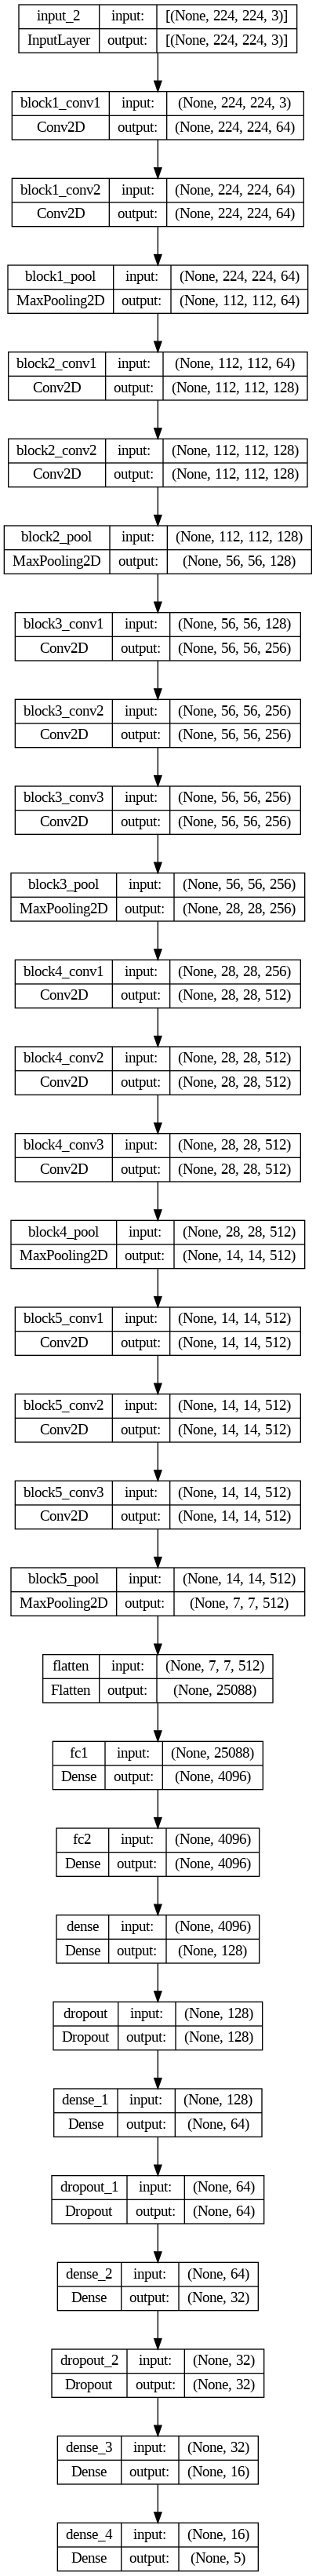

In [10]:
from tensorflow.keras.utils import plot_model

# Save the model summary diagram as an image file
plot_model(classifier1, to_file='/content/drive/My Drive/Final Year 2024 PPS/Sanjeev_doc/vgg_base_truncated_summary.png', show_shapes=True)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=5, verbose=1)

# Train the model with the callback
history1 = classifier1.fit(x_data, y_data, epochs=30, batch_size=64, callbacks=[reduce_lr], validation_split=0.2)


Epoch 1/30
22/22 [==============================] - 8s 346ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - lr: 1.0000e-04
Epoch 2/30
22/22 [==============================] - 7s 342ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - lr: 1.0000e-04
Epoch 3/30
22/22 [==============================] - 8s 345ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - lr: 1.0000e-04
Epoch 4/30
22/22 [==============================] - 8s 352ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - lr: 1.0000e-04
Epoch 5/30
22/22 [==============================] - 9s 404ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - lr: 1.0000e-04
Epoch 6/30
22/22 [==============================] - 9s 401ms/step - loss: 0.0075 - mean_squared_error: 0.

In [ ]:
# Save model architecture, weights, and optimizer state
classifier1.save('/content/drive/My Drive/Final Year 2024 PPS/Sanjeev_doc/post_model_vgg.keras')

# Save training history
np.save('/content/drive/My Drive/Final Year 2024 PPS/Sanjeev_doc/post_history_vgg.npy', history1.history)


In [ ]:
import cv2
import numpy as np

x_gray = []
for img in x_resized:
    img_arr_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_arr_gray_expanded = np.expand_dims(img_arr_gray, axis=-1)
    x_gray.append(img_arr_gray_expanded)
x_gray = np.array(x_gray)
x_gray.shape


(1700, 224, 224, 1)

In [ ]:
x_train=x_resized
y_train=y_resized

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

val_preds=classifier1.predict(x_train)

mse=history1.history['loss'][-1]
val_mse=history1.history['val_loss'][-1]

mae=mean_absolute_error(y_train,val_preds)

rmse=np.sqrt(val_mse)
r2 = r2_score(y_train, val_preds)

# Print the calculated metrics
print("Mean Squared Error (MSE):", mse)
print("Validation Mean Squared Error (val_MSE):", val_mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 score:", r2)

54/54 [==============================] - 15s 160ms/step
Mean Squared Error (MSE): 0.004916129168123007
Validation Mean Squared Error (val_MSE): 0.002907473361119628
Mean Absolute Error (MAE): 0.047273163993323174
Root Mean Squared Error (RMSE): 0.05392099184102262
R^2 score: -3.9468208214485374


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

val_preds=classifier.predict(x_train)

mse=history.history['loss'][-1]
val_mse=history.history['val_loss'][-1]

mae=mean_absolute_error(y_train,val_preds)

rmse=np.sqrt(val_mse)
r2 = r2_score(y_train, val_preds)

# Print the calculated metrics
print("Mean Squared Error (MSE):", mse)
print("Validation Mean Squared Error (val_MSE):", val_mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 score:", r2)

54/54 [==============================] - 7s 128ms/step
Mean Squared Error (MSE): 0.008500359952449799
Validation Mean Squared Error (val_MSE): 0.06367464363574982
Mean Absolute Error (MAE): 0.0991975218910504
Root Mean Squared Error (RMSE): 0.2523383514960614
R^2 score: -25.013922468265445


In [ ]:
x_data=[]
y_data=[]
y_resized=y_resized.astype(float)
y_resized.shape
x_resized.shape
print(y_resized[0])
for i in range(len(y_resized)):
    for j in range(5):
        y_data.append(y_resized[i])
len(y_data)

[0.17 0.19 0.22 0.19 0.23]


8500

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

for img in x_resized:


    datagen = ImageDataGenerator(
    rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    img = img.reshape((1,) + img.shape)


    augmented_images = []
    num_augmented_images = 5  # Number of augmented images to generate

    for _ in range(num_augmented_images):
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0].astype('uint8'))
            break
    for i in augmented_images:


        x_data.append(i)








In [ ]:
print(len(x_data),"  ",len(y_data))
print(x_data[0].shape,"  ",y_data[0].shape)
x_data=np.array(x_data)
y_data=np.array(y_data)
print(x_data.shape,"  ",y_data.shape)

8500    8500
(224, 224, 3)    (5,)
(8500, 224, 224, 3)    (8500, 5)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=5, verbose=1)

# Train the model with the callback
history = classifier.fit(x_data, y_data, epochs=20, batch_size=64, callbacks=[reduce_lr], validation_split=0.2)


Epoch 1/20
107/107 [==============================] - 34s 315ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - lr: 1.0000e-04
Epoch 2/20
107/107 [==============================] - 38s 361ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - lr: 1.0000e-04
Epoch 3/20
107/107 [==============================] - 34s 317ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - lr: 1.0000e-04
Epoch 4/20
107/107 [==============================] - 34s 321ms/step - loss: 9.8109e-04 - mean_squared_error: 9.8109e-04 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - lr: 1.0000e-04
Epoch 5/20
107/107 [==============================] - 38s 354ms/step - loss: 9.5392e-04 - mean_squared_error: 9.5392e-04 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - lr: 1.0000e-04
Epoch 6/20
107/107 [==============================] - ETA: 0s - loss: 9.42

In [ ]:
# Save model architecture, weights, and optimizer state
classifier.save('/content/drive/My Drive/Final Year 2024 PPS/Sanjeev_doc/post_model_vgg_aug.keras')

# Save training history
np.save('/content/drive/My Drive/Final Year 2024 PPS/Sanjeev_doc/post_history_vgg_aug.npy', history.history)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=5, verbose=1)

# Train the model with the callback
history = classifier1.fit(x_data, y_data, epochs=20, batch_size=64, callbacks=[reduce_lr], validation_split=0.2)


Epoch 1/20
107/107 [==============================] - 38s 355ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - lr: 1.0000e-04
Epoch 2/20
107/107 [==============================] - 38s 356ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - lr: 1.0000e-04
Epoch 3/20
107/107 [==============================] - 37s 346ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - lr: 1.0000e-04
Epoch 4/20
107/107 [==============================] - 41s 382ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - lr: 1.0000e-04
Epoch 5/20
107/107 [==============================] - 38s 351ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - lr: 1.0000e-04
Epoch 6/20
107/107 [==============================] - 38s 352ms/step - loss: 0.0035 - mean

In [ ]:
# Save model architecture, weights, and optimizer state
classifier1.save('/content/drive/My Drive/Final Year 2024 PPS/Sanjeev_doc/post_model_vgg_aug1.keras')

# Save training history
np.save('/content/drive/My Drive/Final Year 2024 PPS/Sanjeev_doc/post_history_vgg_aug1.npy', history.history)
